In [96]:
%reset -f

import numpy as np
import copy
import time

from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
import rustworkx as rx

from qiskit_ibm_runtime import Estimator as RuntimeEstimator, QiskitRuntimeService, Options, Session
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from heisenberg_model import HeisenbergModel

import matplotlib.pyplot as plt    

print("Cell Evaluated")


Cell Evaluated


In [97]:
def cryansatz(nqubits, layers, init_bitstring): # Hardware efficient ansatz that is spin preserving.
    
    # Separate physical and "virtual" qubits (i.e. qubits used) 
    # to prevent errors about how the number of qubits don't match.
    # However, gates will only act on the number of used qubits set by the "nqubits" argument.
    
    # From here, we will use the "initial_layout" argument during transpile to map the extra qubits
    # in the circuit to the physical ones we want to avoid (i.e. 0,6,9,15)
    physical_qubits = 16
    
    assert nqubits%2 == 0
    assert nqubits <= physical_qubits
    
    print(f"{'':+^64}\n",
      f"{' Spin Preserving CRY Ansatz (Ring Topo) ':^64}",
      f"\n{'':+^64}")
    
    my_circ = QuantumCircuit(physical_qubits)
    nparams = int((nqubits/2) * layers)
    
    params = ParameterVector('θ', nparams)
    params_idx = 0
    
    for x_ in range(len(init_bitstring)):
        if init_bitstring[x_] == "1":
            my_circ.x(x_)
            
    my_circ.barrier()
    
    for l_ in range(layers):
        if l_%2 ==0:
            for q2_ in range(0, nqubits,2):
                if q2_+1 == nqubits:
                    qb1 = q2_
                    qb2 = 0
                else:
                    qb1 = q2_
                    qb2 = q2_ + 1
                    
                my_circ.cx(qb1, qb2)
                my_circ.cry(params[params_idx], qb2, qb1)
                params_idx += 1
                my_circ.cx(qb1, qb2)
                my_circ.rzz(np.pi/2, qb2, qb1)
        else:
            for q2_ in range(1, nqubits,2):
                if q2_+1 == nqubits:
                    qb1 = q2_
                    qb2 = 0
                else:
                    qb1 = q2_
                    qb2 = q2_ + 1
                    
                my_circ.cx(qb1, qb2)
                my_circ.cry(params[params_idx], qb2, qb1)
                params_idx += 1
                my_circ.cx(qb1, qb2)
                my_circ.rzz(np.pi/2, qb2, qb1)

                
        my_circ.barrier()
                
    return my_circ


def gatecount(circuit):
    return len([circuit.data[gate][0].name for gate in range(len(circuit.data))])


# Guadalupe coupling_map
coupling_map = [[12, 15], [15, 12], [12, 10], [10, 12], 
                [7, 4], [4, 7], [8, 9], [9, 8], 
                [2, 3], [3, 2], [5, 3], [3, 5], 
                [12, 13], [13, 12], [0, 1], [1, 0], 
                [11, 8], [8, 11], [7, 6], [6, 7], 
                [11, 14], [14, 11], [5, 8], [8, 5], 
                [10, 7], [7, 10], [4, 1], [1, 4], 
                [2, 1], [1, 2], [13, 14], [14, 13]]

initial_layout = [1,2,3,5,8,11,14,13,12,10,7,4,0,6,9,15]

# Last 4 qubits are not used. These unused qubits will be mapped to 0, 6, 9 15 on the device
# using initial_layout argument during the transpile stage.
drawansatz = cryansatz(12, 4, '101010101010')

print("Gate count:", gatecount(drawansatz))
print("Depth:", drawansatz.depth())

# drawansatz.draw(fold=5000)



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
              Spin Preserving CRY Ansatz (Ring Topo)              
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Gate count: 107
Depth: 17


# Kagome Lattice Hamiltonian

In [98]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t), (2, 3, t), (3, 5, t), (5, 8, t),
    (8, 11, t), (11, 14, t), (14, 13, t), (13, 12, t),
    (12, 10, t), (10, 7, t), (7, 4, t), (4, 1, t),
    (4, 2, t), (2, 5, t), (5, 11, t), (11, 13, t),
    (13, 10, t), (10, 4, t)]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits

print("Cell Evaluated")



Cell Evaluated


# Plotting some pre-saved runs

Due to queue related issues, these runs were obtained using 1000 shots on a simulator instead. We tried using Qiskit's Aer simulator to run locally and with runtime, and we tried using fakeguadalupe backends. Unfortunately, both of these were too slow. Using runtime for VQE is difficult on a laptop as it required near constant connection to the internet.

However, our results are unlikely to be compromised even if the optimization was carried out on a real backend.

 - Using a relatively low depth excitation preserving ansatz means that only a small subspace of the cost function landscape needs to be explored. Combined with rotosolve, converging to the minimum within the noisy landscape should be quick, allowing for multple runs to be tried. 

 - Noise in the device may cause the optimization landscape to change. With sufficient runs converging with different sets of parameter values, these differences in the landscape should also be reflected when measuring multiple runs $\langle \hat{\mathcal{G}}_1 \rangle$ and $\langle \hat{\mathcal{G}}_2 \rangle$ on the hardware, and should be captured within the scale factor during averaging. 
 

Inside load_saved_dat is a list of runs. Each run is a dictionary with the following keys:
 - `seed`: Starting seed for optimizer, between -π and π. 
 - `opt params`: Optimal parameters for our circuit
 - `cflist`: Cost function values after each optimizer iteration
 - `paramlist`: Theta values after each optimizer iteration


Number of saved runs: 15


Text(0.5, 1.0, 'Plot of multiple runs achieving ground state')

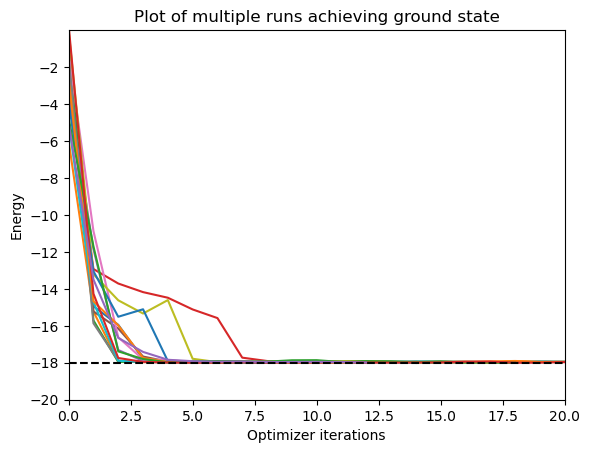

In [99]:


load_saved_dat = np.load("cryansatz-16l4-shots1000-Rotosolvedat.npy", allow_pickle = True)

print(f"Number of saved runs: {len(load_saved_dat)}")
n_plots = len(load_saved_dat)


for _idx in range(len(load_saved_dat)):
    plt.plot(load_saved_dat[_idx]['cflist'])

xplotrange = max([len(load_saved_dat[_idx]['cflist']) for _idx in range(n_plots)])


plt.ylim(-20,0)
plt.xlim(0,20)
plt.yticks([x for x in range(-20,0,2)])
plt.plot([-18 for x in range(-1,xplotrange+1)], linestyle = 'dashed', color='black')
plt.xlabel("Optimizer iterations")
plt.ylabel("Energy")
plt.title("Plot of multiple runs achieving ground state")




### Loading final parameters into ibmq_guadalupe with Runtime's error mitigation and error suppression. 



In [100]:
print("Loading runtime service.... Est wait: 10s")
ttg1 =time.time()
service = QiskitRuntimeService(channel="ibm_quantum",
                               instance='ibm-q-community/ibmquantumawards/open-science-22'
                              ) 

runtime_backend = 'ibmq_guadalupe'
print("Service loaded. Time taken: %.2fs" %(time.time() - ttg1))



Loading runtime service.... Est wait: 10s
Service loaded. Time taken: 15.21s


It is important to fix the options below during the session, as the same options need to be used when using `ibmq_guadalupe` to find the scale factor. 

Once again, we leverage Runtime's ability to send multiple jobs at once to be queued. The first loop is used to send the jobs to the backend. Once all the jobs has been sent, a second loop queries the results and saves them to a list. This saves some overhead as subsequent jobs can be sent without having to wait for earlier ones to finish. 

In [102]:
options = Options()                   # https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.options.Options.html
options.optimization_level = 3        # 3 is Default, https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-suppression.html
options.resilience_level = 2          # 0: none, 1: readout errors (TREX), 2: ZNE, 3: PEC
options.max_execution_time = None
options.execution.shots = 100000      # 4000 is default
options.execution.init_qubits = True  # Reset Qubits after each shot
options.transpilation.skip_transpilation = True # Don't transpile using qiskit_ibm_runtime.Options... EVER

print("Preparing runtime session....")
klfado = time.time()

with Session(service=service, backend=runtime_backend) as session:
    
    rtestimator = RuntimeEstimator(session=session, options=options)
    saved_circ = cryansatz(12, 4, '101010101010')
    saved_circ = transpile(saved_circ, 
                       initial_layout=[1,2,3,5,8,11,14,13,12,10,7,4,0,6,9,15],
                       optimization_level=3,
                       basis_gates=['cx', 'id', 'rz', 'sx', 'x'],
                       coupling_map = coupling_map,
                       seed_transpiler = 16
                      )
    
 
    print("Depth:", saved_circ.depth())
    print("Gate count:", sum(saved_circ.count_ops().values()))
    print("Nonlocal gate count:", saved_circ.num_nonlocal_gates())

    
    # Printing the energy from these runs. Won't get exactly -18 due to statistical error from noisy measurements
    joblist = []
    job_id_list = []
    seedlist = []
    
    print("Running circuits.... ")
    for stpt in load_saved_dat: 

        xx = stpt['opt params']
        opt_job = rtestimator.run([saved_circ], [ham_16], [xx])
        joblist.append(opt_job)
        job_id_list.append(opt_job.job_id())
        seedlist.append(stpt['seed'])
        print(f">>> Stpt: {stpt['seed']}, Job ID: {opt_job.job_id()}, Job Status: {opt_job.status()}")
    
    
    session_id = session.session_id
    print()
    print(f"All jobs sent! Session ID: {session_id}. Awaiting results....")
    print()
    
    session.close()
        

print(f"Time taken: {(time.time() - klfado):<5.3f}s")




Preparing runtime session....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
              Spin Preserving CRY Ansatz (Ring Topo)              
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Depth: 73
Gate count: 539
Nonlocal gate count: 96
Running circuits.... 
>>> Stpt: 21386, Job ID: cgsq2ab7iuhj2v489j00, Job Status: JobStatus.QUEUED
>>> Stpt: 19140, Job ID: cgsq2atc26uins2mofh0, Job Status: JobStatus.QUEUED
>>> Stpt: 25906, Job ID: cgsq2b5evgbv2i5soo60, Job Status: JobStatus.QUEUED
>>> Stpt: 33865, Job ID: cgsq2b82tle0vokd602g, Job Status: JobStatus.QUEUED
>>> Stpt: 10259, Job ID: cgsq2bj7iuhj2v489l70, Job Status: JobStatus.QUEUED
>>> Stpt: 21683, Job ID: cgsq2c5evgbv2i5soqg0, Job Status: JobStatus.QUEUED
>>> Stpt: 15708, Job ID: cgsq2c82tle0vokd62a0, Job Status: JobStatus.QUEUED
>>> Stpt: 11744, Job ID: cgsq2cg2tle0vokd62s0, Job Status: JobStatus.QUEUED
>>> Stpt: 16811, Job ID: cgsq2ctevgbv2i5sosp0, Job Status: JobStatus.QUEUED
>>> Stpt: 19705, 

In [ ]:
print("Loading job services...")

# my_session_id = 'cgsq2ab7iuhj2v489j00'                          # If we want to load existing session-ids

my_session_id = session_id
my_job_list = service.jobs(limit=None, session_id=my_session_id ,descending=True)

njobs = len(my_job_list)
seedlist = [stpt['seed'] for stpt in load_saved_dat]

print("Retrieving job results...")
tkfg1 = time.time()

job_id_list = []
noisy_sim_with_mitig = []     
for idx in range(njobs):
    
    # Print status first in case job is not ready to pull the result.
    print(f"Job ID: {my_job_list[idx].job_id()}, Status: {my_job_list[idx].status()},")
    
    job_result = my_job_list[idx].result().values[0]
    noisy_sim_with_mitig.append(job_result)
    job_id_list.append(my_job_list[idx].job_id())


print(f">>> Exp values (backend): {noisy_sim_with_mitig}, Time taken: {(time.time() - tkfg1):<5.3}s")

In [33]:
savedict = dict({})
savedict["shots"] = options.execution.shots
savedict["hbknd"] = noisy_sim_with_mitig
savedict["sessid"] = my_session_id
savedict["jobid"] = job_id_list
savedict["stptlist"] = seedlist

saved_filename = "KagomeExpvalData-Guadalupe-"+str(options.execution.shots)+".npy"
np.save(saved_filename,savedict)
print("Data saved")



Data saved


# Loading the saved files...

Here, we load the saved files from the results after excuting on the `ibmq_guadalupe` backend, which includes our data for the scale factor $\mathcal{\vec{f}} = \{ {\mathcal{f}_1, ... , \mathcal{f}_I} \}$ and our measured expectation values $\{ \langle \hat{H}_{\textrm{kagome}}  \rangle _1 , ..., \langle \hat{H}_{\textrm{kagome}}  \rangle _J\}$.


What we want is to obtain

\begin{align*}
E_{\textrm{kagome}}^{ij} = \mathcal{f}_i \langle \hat{H}_{\textrm{kagome}}  \rangle_j
\end{align*}



In [94]:
expvaldat = np.load(saved_filename, allow_pickle=True).item()
sfdat = np.load("ScaleFactorData-Guadalupe-"+str(options.execution.shots)+".npy", allow_pickle=True).item()


### If we want to load existing saved data
# expvaldat = np.load("KagomeExpvalData-Noisy-100000.npy", allow_pickle=True).item()
# sfdat = np.load("scalefactordata-Noisy-100000.npy", allow_pickle=True).item()


In [95]:

mymat = np.outer(expvaldat['hbknd'], sfdat['meanf'])


print(f"Matrix size: {mymat.shape}. Number of elements: {mymat.size}")
print(f"Values within 1% bound: {mymat[np.where( (-18.18<= mymat) &  (mymat<= -17.82))]}")
print(f"Matrix mean: {np.mean(mymat):<8.5f}, std: {np.std(mymat):<8.5f}")
print(f"<H> mean: {np.mean(expval_list):<8.5f}, std: {np.std(expval_list):<8.5f}")
print(f"Scale factor mean: {np.mean(scalfac_list):<8.5f}, std: {np.std(scalfac_list):<8.5f}")

Matrix size: (15, 15). Number of elements: 225
Values within 1% bound: [-17.93676429 -17.88578856 -17.95637594 -18.15898126 -17.88394955
 -18.0038712  -17.82031115 -18.1570299  -18.02227558 -18.14372001
 -18.10258509 -18.12220381 -17.88634292 -17.99553076 -18.13098356
 -18.05351704 -17.8817129  -18.13978644 -18.16418877 -18.00221013
 -17.96139604 -17.9936812  -18.11493294 -18.07386328 -18.13443637
 -17.89841628 -18.05713863 -18.11963082 -18.0130608  -18.13444313
 -18.09332924 -17.83942613 -18.04071188]
Matrix mean: -17.83198, std: 0.72370 
<H> mean: -9.45211, std: 1.21397 
Scale factor mean: 1.79974 , std: 0.15904 


Text(0, 0.5, 'Population')

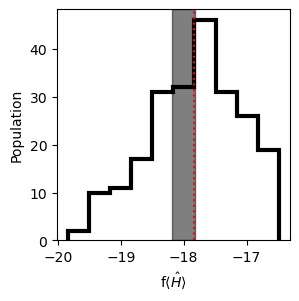

In [91]:
fig, ax = plt.subplots(dpi=100, figsize=(3,3))
counts, bins = np.histogram(mymat.flatten())
ax.stairs(counts, bins, color='k', linewidth=3)
ax.axvspan(-18.18,-17.82, color='k', alpha=0.5)
# ax.axvline(x=-17.82, color='k', linestyle='dotted')
ax.axvline(x=-17.83198, color='r', linestyle='dotted')
ax.set_xlabel(r'f$\langle \hat{H} \rangle$')
ax.set_ylabel('Population')